## 1. Setup and Data Preparation

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading & Initial Type Conversions

In [45]:
file_path = 'ukrailways/Cleaned_UKRailways_Data.csv'
TARGET_COLUMN = 'Date of Journey'
try:
    df = pd.read_csv(file_path)
    print(f"✅ Successfully loaded file: {file_path}")
except FileNotFoundError:
    print(f"❌ Error: File not found at the specified path: {file_path}")
    
# 1. Clean up leading/trailing spaces from all column headers
df.columns = df.columns.str.strip() 

# 2. Forceful Fix for 'Date of Journey' KeyError
renamed = False

# Find the column that contains 'journey' (case-insensitive) and rename it
for col in df.columns:
    if 'journey' in col.lower():
        df = df.rename(columns={col: TARGET_COLUMN})
        renamed = True
        break
        
if renamed:
    print(f"✅ Column name successfully fixed and set to '{TARGET_COLUMN}'.")
else:
    print(f"⚠️ Warning: Column name containing 'journey' was not found.")


# 3. Convert Date and Time columns
df[TARGET_COLUMN] = pd.to_datetime(df[TARGET_COLUMN])
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M:%S', errors='coerce')
df['Departure Time'] = pd.to_datetime(df['Departure Time'], format='%H:%M:%S', errors='coerce')

print("\nInitial data structure:")
print(df.head())


✅ Successfully loaded file: ukrailways/Cleaned_UKRailways_Data.csv
✅ Column name successfully fixed and set to 'Date of Journey'.

Initial data structure:
            Transaction ID Date of Purchase Time of Purchase Purchase Type  \
0  da8a6ba8-b3dc-4677-b176       2023-12-08         12:41:11        Online   
1  b0cdd1b0-f214-4197-be53       2023-12-16         11:23:01       Station   
2  f3ba7a96-f713-40d9-9629       2023-12-19         19:51:27        Online   
3  b2471f11-4fe7-4c87-8ab4       2023-12-20         23:00:36       Station   
4  2be00b45-0762-485e-a7a3       2023-12-27         18:22:56        Online   

  Payment Method     Railcard Ticket Class Ticket Type  Price  \
0    Contactless        Adult     Standard     Advance     43   
1    Credit Card        Adult     Standard     Advance     23   
2    Credit Card  No Railcard     Standard     Advance      3   
3    Credit Card  No Railcard     Standard     Advance     13   
4    Contactless  No Railcard     Standard     Adva

In [22]:
df['Reason for Delay'] = df['Reason for Delay'].replace({
    'Staffing': 'Staffing Issue',
    'Staff Shortage': 'Staffing Issue',
    'Signal failure': 'Signal Failure',
    'Signal Failure': 'Signal Failure',
    'Weather': 'Weather Conditions',
    'Weather Conditions': 'Weather Conditions'})

## 3. Future Engineering (Creating Net Revenue and Segments)

In [46]:
## This cell calculates the necessary columns for profitability and segmentation analysis.

# Define exact column names confirmed from data
PRICE_COL = 'Price'
REFUND_REQ_COL = 'Refund Request'
DATE_COL = 'Date of Journey'
DEPARTURE_STATION_COL = 'Departure Station'
ARRIVAL_DESTINATION_COL = 'Arrival Destination'
RAILCARD_COL = 'Railcard'
TICKET_TYPE_COL = 'Ticket Type'
ARR_TIME_COL = 'Arrival Time'
DEP_TIME_COL = 'Departure Time'

# --- 1. Diagnostic Check for Dependencies ---
REQUIRED_COLS = [PRICE_COL, REFUND_REQ_COL]
missing_cols = [col for col in REQUIRED_COLS if col not in df.columns]

if missing_cols:
    print(f"❌ CRITICAL ERROR: Cannot calculate Net_Revenue. Missing column(s): {missing_cols}")
    raise KeyError("Dependency columns for Net_Revenue are missing. Fix the names above in Cell 3.")

# --- 2. Time Conversions ---
try:
    df[ARR_TIME_COL] = pd.to_datetime(df[ARR_TIME_COL], format='%H:%M:%S', errors='coerce')
    df[DEP_TIME_COL] = pd.to_datetime(df[DEP_TIME_COL], format='%H:%M:%S', errors='coerce')
except KeyError:
    print("❌ Warning: Time columns were not found for duration calculation.")

# --- 3. Creation of Profitability Features ---

# Route
df['Route'] = df[DEPARTURE_STATION_COL] + ' - ' + df[ARRIVAL_DESTINATION_COL]

# Net Revenue and Refund Amount Calculation
df['Refund_Requested'] = df[REFUND_REQ_COL].map({'Yes': 1, 'No': 0})
REFUND_PERCENTAGE = 0.5
df['Refund_Amount'] = np.where(df['Refund_Requested'] == 1, df[PRICE_COL] * REFUND_PERCENTAGE, 0)
df['Net_Revenue'] = df[PRICE_COL] - df['Refund_Amount']

# --- 4. Passenger Segments (THE FIX) ---
# FIX: Check if the value is the *string* 'No Railcard' or anything else (which implies a type of Railcard)
df['Has_Railcard'] = df[RAILCARD_COL].apply(
    lambda x: 'No Railcard' if x == 'No Railcard' else 'Railcard User'
)
df['Is_Group_Booking'] = df[TICKET_TYPE_COL].apply(lambda x: 1 if x == 'Group' else 0)
df['Passenger_Segment'] = df['Has_Railcard'] 

# --- 5. Journey Duration ---
df['Journey_Duration_Minutes'] = (df[ARR_TIME_COL] - df[DEP_TIME_COL]).dt.total_seconds() / 60
df['Journey_Duration_Minutes'] = df['Journey_Duration_Minutes'].fillna(df['Journey_Duration_Minutes'].median())

print("✅ Derived features (Net_Revenue, Route, etc.) created successfully.")

✅ Derived features (Net_Revenue, Route, etc.) created successfully.


## 4. Time Series Aggregation & Dummy Forecasting Data

In [11]:
# --- Aggregation for Forecasting Models ---

# Define columns required for aggregation
DATE_COL = 'Date of Journey'
NET_REVENUE_COL = 'Net_Revenue'
PRICE_COL = 'Price'
TRANS_ID_COL = 'Transaction ID'
TICKET_CLASS_COL = 'Ticket Class'

# --- 1. Final Diagnostic Check for ALL Dependencies ---
REQUIRED_COLS = [DATE_COL, NET_REVENUE_COL, PRICE_COL, TRANS_ID_COL, TICKET_CLASS_COL]
missing_cols = [col for col in REQUIRED_COLS if col not in df.columns]

if missing_cols:
    print("\n❌ CRITICAL ERROR: The required column(s) are missing from the DataFrame.")
    print(f"Missing column(s) that must exist: {missing_cols}")
    print("\nAction Required: Go back and fix the column name in Cell 3 (for Net_Revenue) or Cell 2 (for basic columns).")
    raise KeyError("Dependency missing. Cannot proceed with aggregation.")
    
print(f"✅ All required columns are present: {DATE_COL} and {NET_REVENUE_COL}.")

# --- 2. Daily Time Series Aggregation ---

# Grouping and aggregation (using only confirmed names)
df_daily_ts = df.groupby(DATE_COL).agg(
    Total_Rides=(TRANS_ID_COL, 'count'),
    Total_Net_Revenue=(NET_REVENUE_COL, 'sum'), 
    Total_Gross_Revenue=(PRICE_COL, 'sum')
)
# We set the index explicitly after aggregation, which is safer
df_daily_ts.index.name = DATE_COL 

# --- 3. Time Series for Demand by Ticket Class ---
df_class_demand = df.groupby([DATE_COL, TICKET_CLASS_COL]).size().reset_index(name='Rides')
df_demand_pivot = df_class_demand.pivot_table(
    index=DATE_COL,
    columns=TICKET_CLASS_COL,
    values='Rides',
    fill_value=0
)

# ... (rest of the dummy demand generation code follows)
demand_data = df_demand_pivot.sum().reset_index(name=0) 
demand_data.columns = [TICKET_CLASS_COL, 'Predicted_Demand']

df_demand = pd.DataFrame({
    'Ticket_Class': demand_data[TICKET_CLASS_COL],
    'Predicted_Demand': demand_data['Predicted_Demand'] * 1.05
})

print("✅ Time Series data prepared for modeling.")

✅ All required columns are present: Date of Journey and Net_Revenue.
✅ Time Series data prepared for modeling.


## 5. Real Forecasting using scikit-learn Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
from datetime import date, timedelta
import numpy as np
import pandas as pd

# 1. Prepare data for modeling
df_model = df_daily_ts.copy().reset_index()
# Create a numerical trend feature: number of days since the start
df_model['Day_Index'] = (df_model['Date of Journey'] - df_model['Date of Journey'].min()).dt.days

# Features (X): Day_Index. Target (Y): Total_Rides, Total_Net_Revenue
X_train = df_model[['Day_Index']]

# 2. Train Models for Rides and Revenue
# Note: Using 'Total_Rides' and 'Total_Net_Revenue' which were created in Cell 4
model_rides = LinearRegression().fit(X_train, df_model['Total_Rides'])
model_revenue = LinearRegression().fit(X_train, df_model['Total_Net_Revenue'])

# 3. Setup Future Dates (Next 30 days)
num_days_forecast = 30
last_day_index = df_model['Day_Index'].max()
last_date = df_model['Date of Journey'].max()

# Create future Day_Index values
X_future = pd.DataFrame({'Day_Index': np.arange(last_day_index + 1, last_day_index + 1 + num_days_forecast)})

# Create future dates
future_dates = pd.to_datetime([last_date + timedelta(days=i) for i in range(1, num_days_forecast + 1)])

# 4. Generate Predictions (Creates df_forecast_real)
forecasted_rides = model_rides.predict(X_future).clip(min=0)
forecasted_revenue = model_revenue.predict(X_future).clip(min=0)

# Create the final forecast DataFrame (df_forecast_real)
df_forecast_real = pd.DataFrame({
    'Forecast_Date': future_dates,
    'Forecasted_Rides': forecasted_rides.round(0),
    'Forecasted_Net_Revenue': forecasted_revenue,
    'Forecasted_Gross_Revenue': forecasted_revenue * 1.10 
})

print("✅ Real forecasts generated using scikit-learn Linear Regression.")
print("Forecasted data (first 5 days):")
print(df_forecast_real.head())

✅ Real forecasts generated using scikit-learn Linear Regression.
Forecasted data (first 5 days):
  Forecast_Date  Forecasted_Rides  Forecasted_Net_Revenue  \
0    2024-05-01             266.0             6091.970248   
1    2024-05-02             266.0             6093.942664   
2    2024-05-03             266.0             6095.915079   
3    2024-05-04             266.0             6097.887495   
4    2024-05-05             266.0             6099.859911   

   Forecasted_Gross_Revenue  
0               6701.167273  
1               6703.336930  
2               6705.506587  
3               6707.676244  
4               6709.845902  


# SECTION 1 - Core Forecasts

## - Historical & Forecasted Daily Rides

### This line chart visualizes the trend and the 30-day forecast for total daily rides.

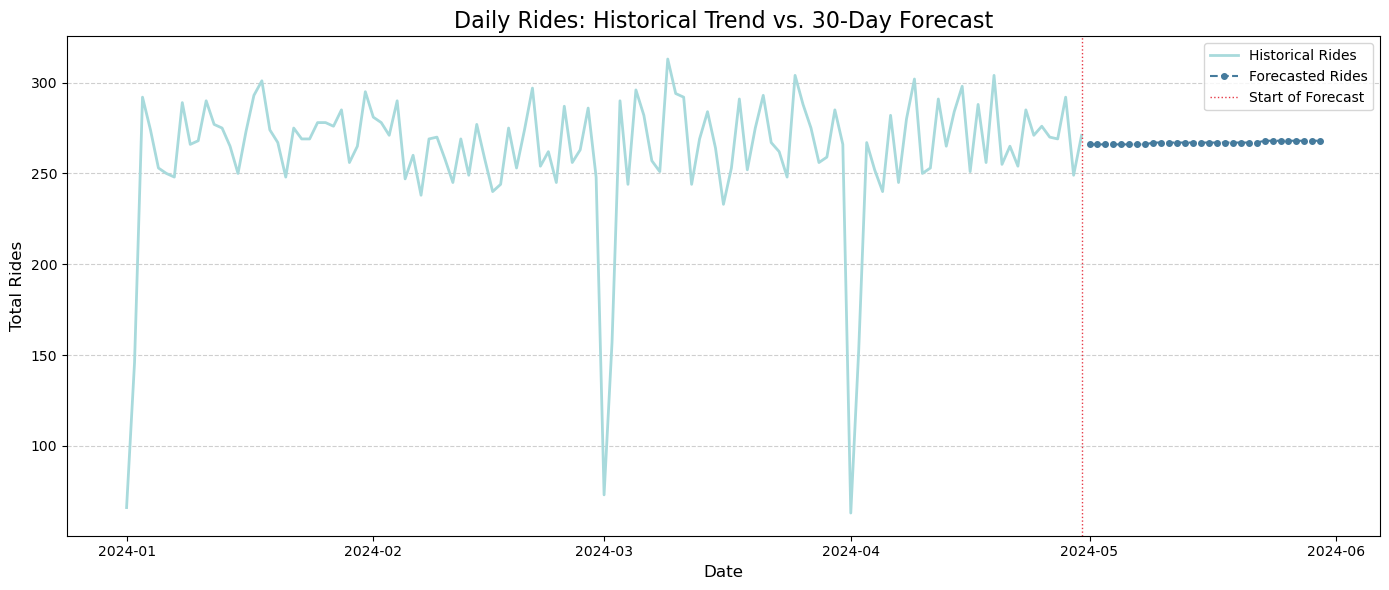

In [47]:
HISTORICAL_COLOR = '#A8DADC' 
FORECAST_COLOR = '#457B9D'   

plt.figure(figsize=(14, 6))

# 1. Plot Historical Data
plt.plot(df_daily_ts.index, df_daily_ts['Total_Rides'], 
         label='Historical Rides', color=HISTORICAL_COLOR, linewidth=2)

# 2. Plot Forecast Data
plt.plot(df_forecast_real['Forecast_Date'], df_forecast_real['Forecasted_Rides'], 
         label='Forecasted Rides', color=FORECAST_COLOR, linestyle='--', marker='o', markersize=4)

# 3. Highlight the forecast period
last_hist_date = df_daily_ts.index.max()
plt.axvline(x=last_hist_date, color='#E63946', linestyle=':', linewidth=1, label='Start of Forecast')

plt.title('Daily Rides: Historical Trend vs. 30-Day Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Rides', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Forecasted_Rides.png')
plt.show()

## - Historical & Forecasted Daily Revenue


### This chart combines historical and forecasted revenue, showing the difference between Net and Gross Revenue.

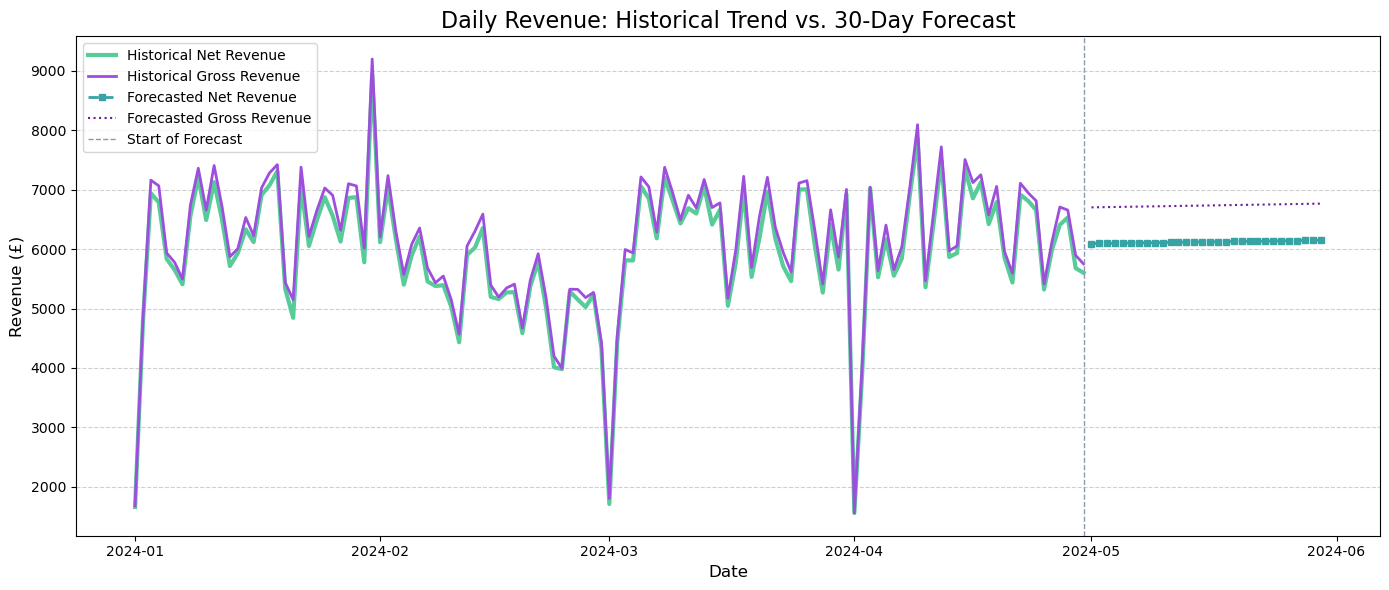

In [49]:
NET_COLOR_HIST = '#57CC99' 
GROSS_COLOR_HIST = '#9D4EDD'
NET_COLOR_FC = '#38A3A5'
GROSS_COLOR_FC = '#6A1D9E'

plt.figure(figsize=(14, 6))

# 1. Plot Historical Data 
plt.plot(df_daily_ts.index, df_daily_ts['Total_Net_Revenue'], 
         label='Historical Net Revenue', color=NET_COLOR_HIST, linewidth=3) 
plt.plot(df_daily_ts.index, df_daily_ts['Total_Gross_Revenue'], 
         label='Historical Gross Revenue', color=GROSS_COLOR_HIST, linewidth=2, linestyle='-') 


# 2. Plot Forecast Data 
last_hist_date = df_daily_ts.index.max()

plt.plot(df_forecast_real['Forecast_Date'], df_forecast_real['Forecasted_Net_Revenue'], 
         label='Forecasted Net Revenue', color=NET_COLOR_FC, linestyle='--', linewidth=2, marker='s', markersize=4) 
plt.plot(df_forecast_real['Forecast_Date'], df_forecast_real['Forecasted_Gross_Revenue'], 
         label='Forecasted Gross Revenue', color=GROSS_COLOR_FC, linestyle=':', linewidth=1.5) 


# 3. Highlight the forecast period
plt.axvline(x=last_hist_date, color='#8D99AE', linestyle='--', linewidth=1, label='Start of Forecast')

plt.title('Daily Revenue: Historical Trend vs. 30-Day Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('Forecasted_Revenue_GreenPurple.png')
plt.show()

## - Top 5 Ticket Class Demand

### This bar chart visualizes which ticket classes are predicted to drive the most future demand.

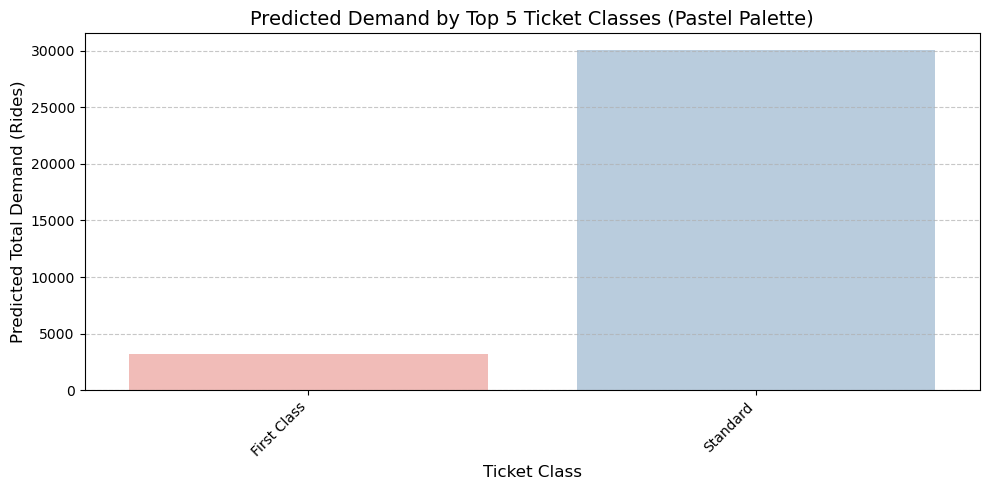

In [15]:
plt.figure(figsize=(10, 5))

sns.barplot(x='Ticket_Class', y='Predicted_Demand', data=df_demand, palette='Pastel1')

plt.title('Predicted Demand by Top 5 Ticket Classes (Pastel Palette)', fontsize=14)
plt.xlabel('Ticket Class', fontsize=12)
plt.ylabel('Predicted Total Demand (Rides)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Top_Demand_Pastel.png')
plt.show()

# SECTION 2: Revenue & Price Insights

## - Net Revenue Growth Trend (Monthly)

### This line chart shows the overall monthly growth or decline in net revenue over the historical period.

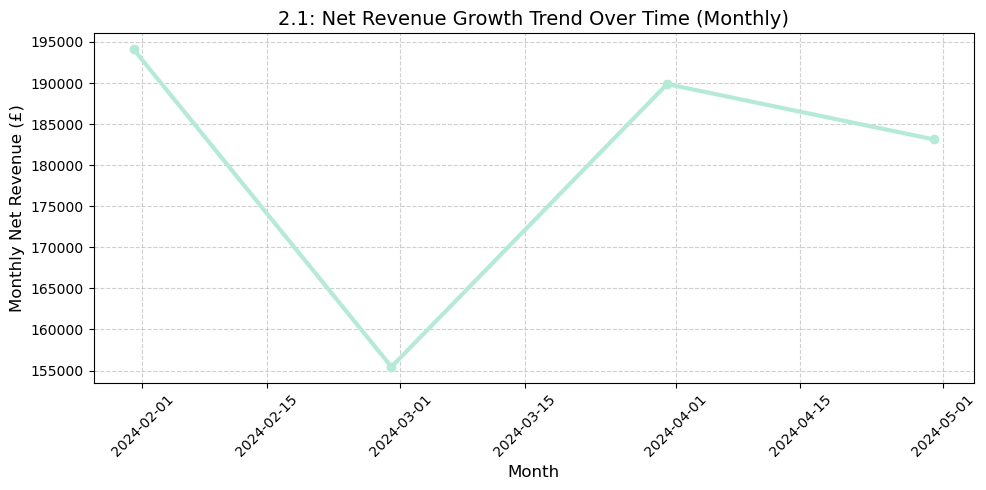

In [50]:
df_monthly_revenue = df.set_index('Date of Journey')['Net_Revenue'].resample('M').sum().reset_index()

plt.figure(figsize=(10, 5))

plt.plot(df_monthly_revenue['Date of Journey'], df_monthly_revenue['Net_Revenue'], 
         marker='o', color='#B5EAD7', linewidth=3)
plt.title('2.1: Net Revenue Growth Trend Over Time (Monthly)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Monthly Net Revenue (£)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Monthly_Revenue_Trend.png')
plt.show()

## - Ticket Price Distribution

### This histogram shows how ticket prices are distributed, helping to identify common price points.

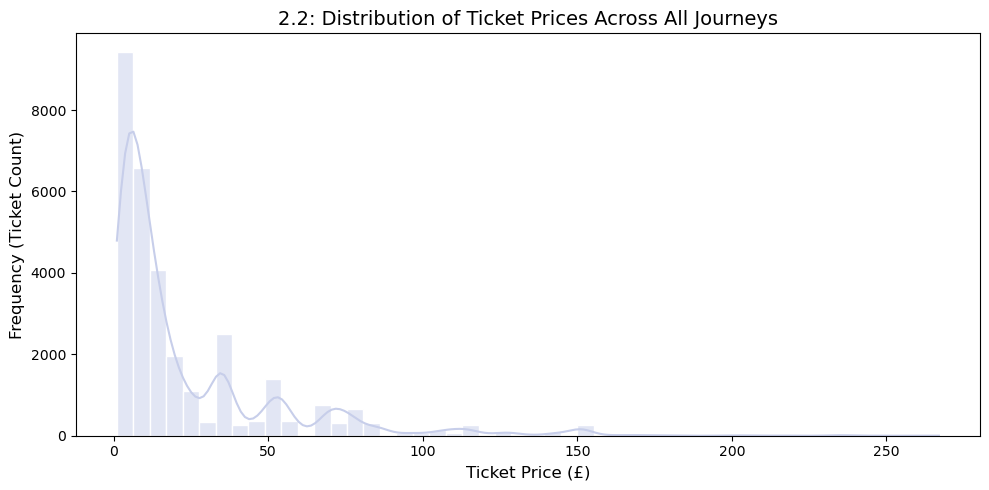

In [17]:
plt.figure(figsize=(10, 5))

sns.histplot(df['Price'], bins=50, kde=True, color='#C7CEEA', edgecolor='white') 
plt.title('2.2: Distribution of Ticket Prices Across All Journeys', fontsize=14)
plt.xlabel('Ticket Price (£)', fontsize=12)
plt.ylabel('Frequency (Ticket Count)', fontsize=12)
plt.tight_layout()
plt.savefig('Price_Distribution.png')
plt.show()

## - Average Ticket Price Per Class

### This bar chart compares the mean price of tickets across different classes (Standard, First, etc.).

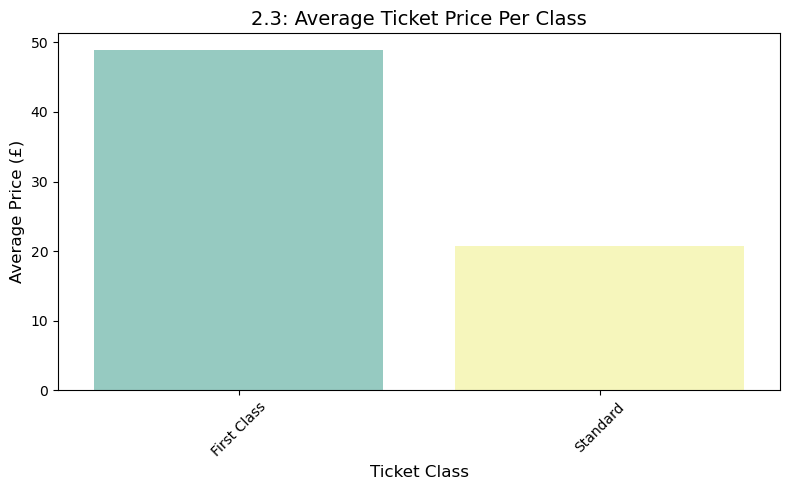

In [18]:
df_price_class = df.groupby('Ticket Class')['Price'].mean().reset_index().sort_values(by='Price', ascending=False)

plt.figure(figsize=(8, 5))

sns.barplot(x='Ticket Class', y='Price', data=df_price_class, palette='Set3')
plt.title('2.3: Average Ticket Price Per Class', fontsize=14)
plt.xlabel('Ticket Class', fontsize=12)
plt.ylabel('Average Price (£)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Avg_Price_by_Class.png')
plt.show()

## - Price Elasticity of Demand

### This scatter plot uses scikit-learn's Linear Regression to visualize the relationship between price and demand (ride volume), indicating elasticity.

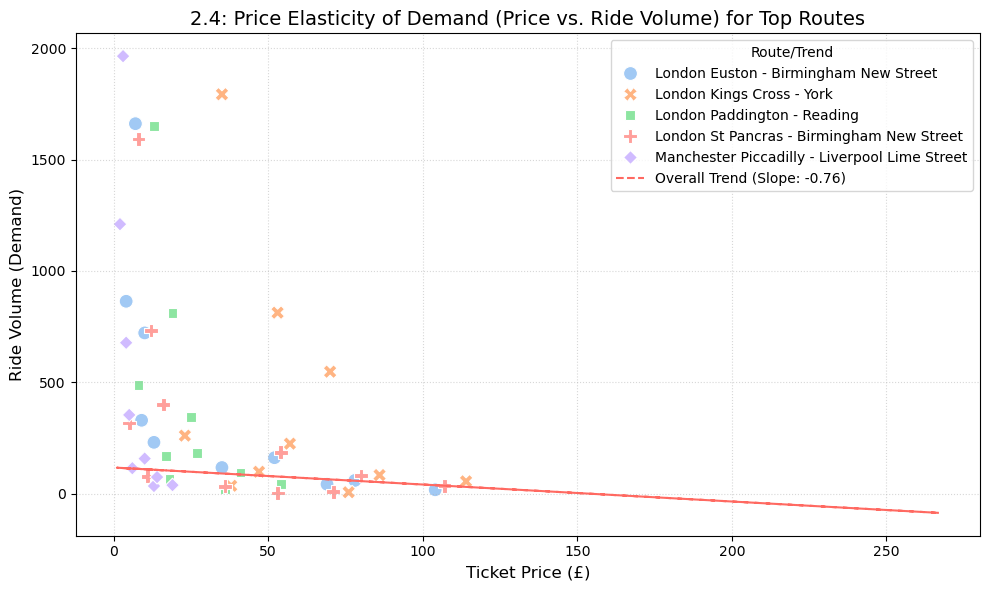

Scikit-learn Note: The overall regression slope is -0.76. A negative value indicates demand generally decreases as price increases (elasticity).


In [59]:
from sklearn.linear_model import LinearRegression

# Aggregate data to find demand (Ride_Volume) for each Route/Price combination
df_elasticity = df.groupby(['Route', 'Price']).size().reset_index(name='Ride_Volume')

# Select top 5 routes for visualization clarity
top_routes = df['Route'].value_counts().head(5).index
df_elasticity_top = df_elasticity[df_elasticity['Route'].isin(top_routes)]

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Price', y='Ride_Volume', hue='Route', data=df_elasticity_top, style='Route', s=100, palette='pastel') 
plt.title('2.4: Price Elasticity of Demand (Price vs. Ride Volume) for Top Routes', fontsize=14)
plt.xlabel('Ticket Price (£)', fontsize=12)
plt.ylabel('Ride Volume (Demand)', fontsize=12)

# Apply Overall Linear Regression (Scikit-learn)
X = df_elasticity['Price'].values.reshape(-1, 1)
y = df_elasticity['Ride_Volume'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot overall trendline
plt.plot(X, y_pred, color='#FF6961', linestyle='--', label=f'Overall Trend (Slope: {model.coef_[0]:.2f})') 
plt.legend(title='Route/Trend')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.savefig('Price_Elasticity.png')
plt.show()

print(f"Scikit-learn Note: The overall regression slope is {model.coef_[0]:.2f}. A negative value indicates demand generally decreases as price increases (elasticity).")

# SECTION 3: Delays & Refunds 

## - Journey Status Distribution

### This pie chart visualizes the proportion of journeys that were On Time versus Delayed.

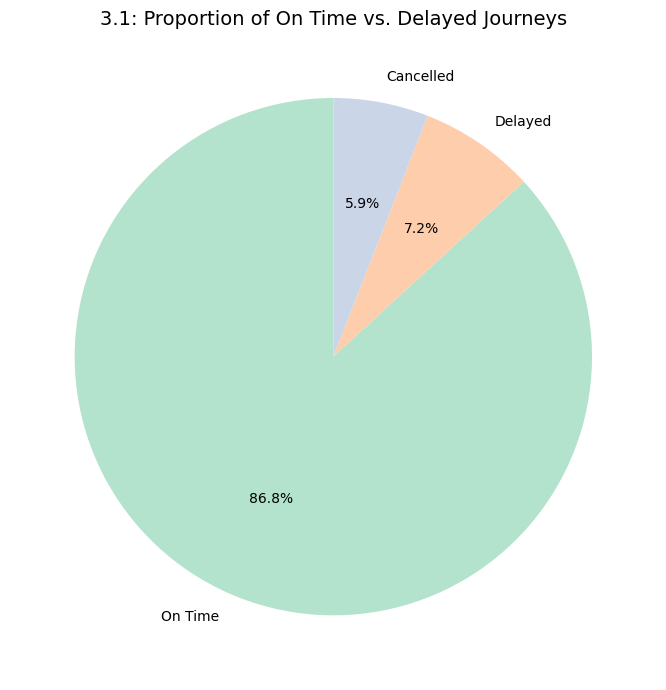

In [20]:
df_status_counts = df['Journey Status'].value_counts()

plt.figure(figsize=(7, 7))
# Use a distinct, light pastel palette
plt.pie(df_status_counts, 
        labels=df_status_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette('Pastel2'))

plt.title('3.1: Proportion of On Time vs. Delayed Journeys', fontsize=14)
plt.tight_layout()
plt.savefig('Journey_Status_Pie.png')
plt.show()

## - Average Delay Duration by Reason

### This bar chart shows which reasons lead to the longest average delays.

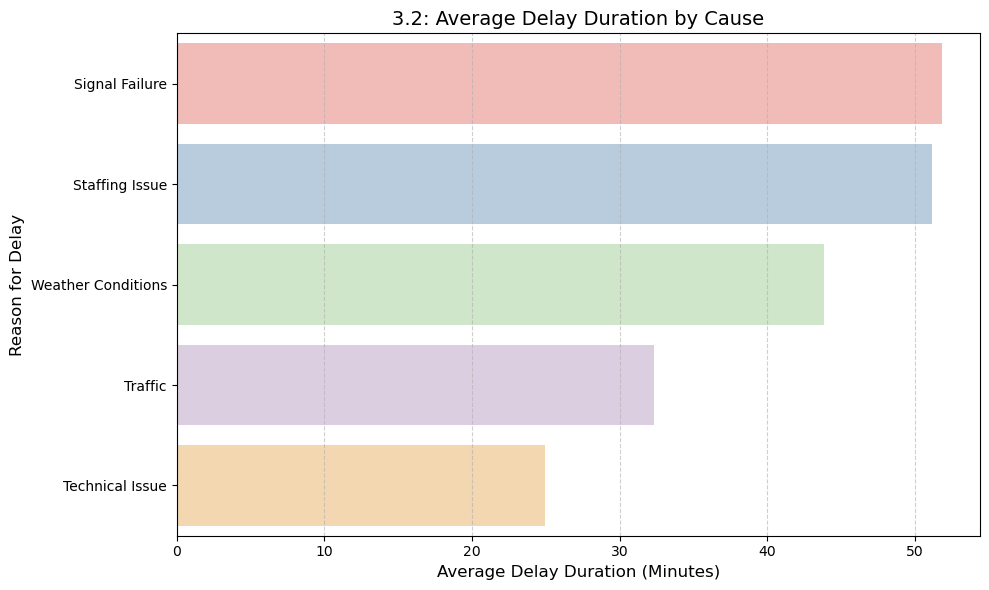

In [23]:
# Filter out 'No Delay' for meaningful analysis of delay reasons
df_delays = df[df['Journey Status'] == 'Delayed'].copy()
df_delay_reason = df_delays.groupby('Reason for Delay')['Delay Duration (min)'].mean().reset_index()
df_delay_reason = df_delay_reason.sort_values(by='Delay Duration (min)', ascending=False)

plt.figure(figsize=(10, 6))
# Use a warm, soft pastel palette
sns.barplot(x='Delay Duration (min)', y='Reason for Delay', data=df_delay_reason, palette='Pastel1')

plt.title('3.2: Average Delay Duration by Cause', fontsize=14)
plt.xlabel('Average Delay Duration (Minutes)', fontsize=12)
plt.ylabel('Reason for Delay', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Avg_Delay_by_Reason.png')
plt.show()

## - Impact of Delays on Net Revenue

### This box plot compares the distribution of Net Revenue for journeys that resulted in a refund request versus those that did not.

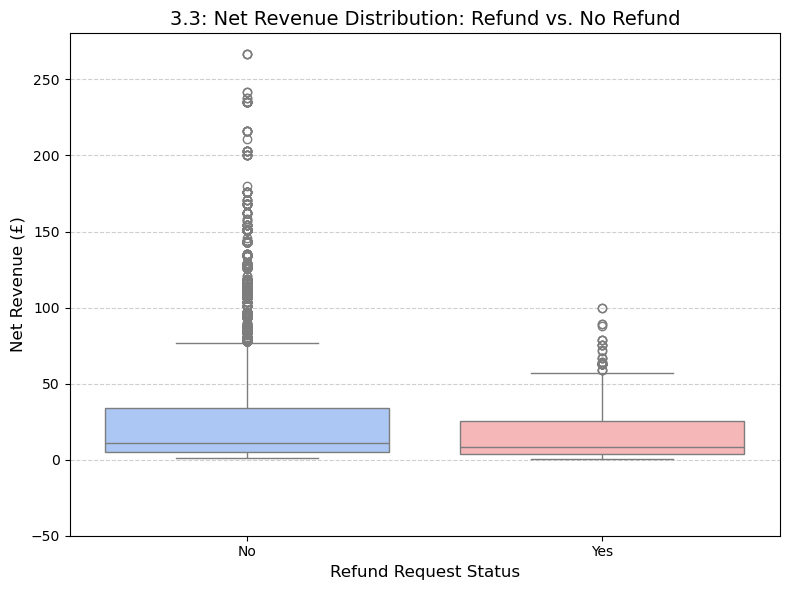

In [25]:
plt.figure(figsize=(8, 6))
# Use a contrasting two-tone pastel palette
sns.boxplot(x='Refund Request', y='Net_Revenue', data=df, palette=['#A0C4FF', '#FFADAD']) # Soft Blue and Red Pastels
plt.title('3.3: Net Revenue Distribution: Refund vs. No Refund', fontsize=14)
plt.xlabel('Refund Request Status', fontsize=12)
plt.ylabel('Net Revenue (£)', fontsize=12)
plt.ylim(bottom=-50) # Allow negative values for refunds, but prevent excessive outliers from skewing scale
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Refund_Impact_on_Revenue.png')
plt.show()


# SECTION 4: Route & Segment Profitability

## - Top 10 Most Profitable Routes (Total Net Revenue)

### This bar chart highlights the routes that generated the highest total net revenue.

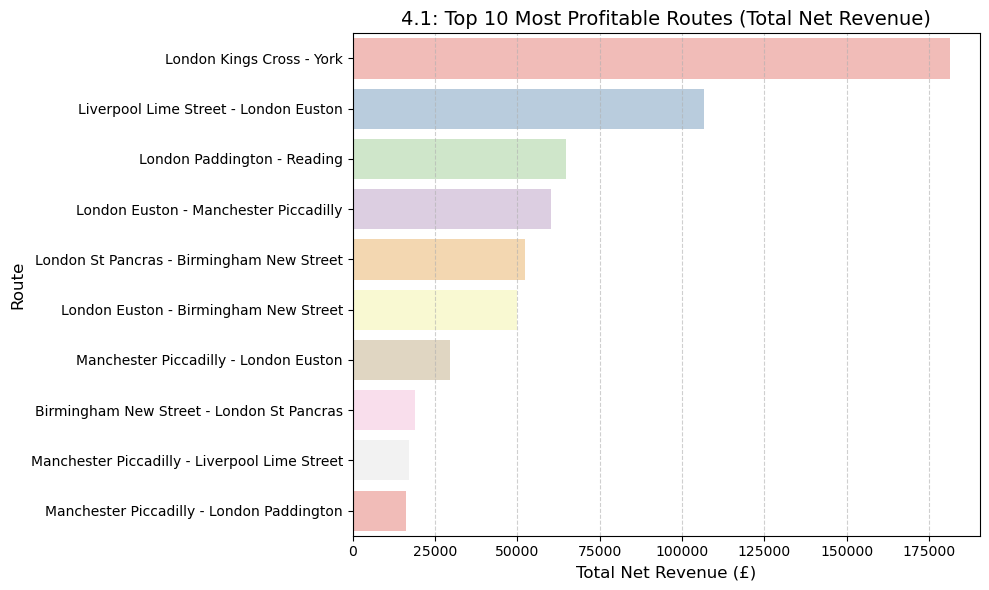

In [53]:
df_route_profit = df.groupby('Route')['Net_Revenue'].sum().reset_index()
df_route_profit = df_route_profit.sort_values(by='Net_Revenue', ascending=False).head(10)

plt.figure(figsize=(10, 6))

sns.barplot(x='Net_Revenue', y='Route', data=df_route_profit, palette='Pastel1')

plt.title('4.1: Top 10 Most Profitable Routes (Total Net Revenue)', fontsize=14)
plt.xlabel('Total Net Revenue (£)', fontsize=12)
plt.ylabel('Route', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.ticklabel_format(style='plain', axis='x') 
plt.tight_layout()
plt.savefig('Top_10_Routes.png')
plt.show()

## - Profitability by Passenger Segment (Railcard vs. No Railcard)

### This chart compares the average net revenue generated by users with a railcard versus those without.

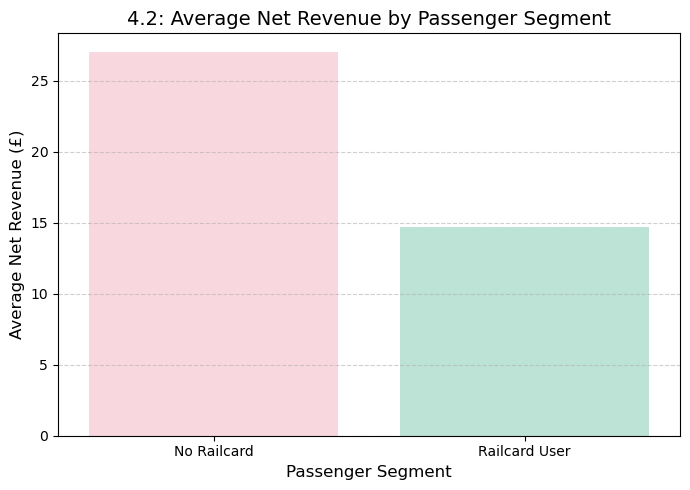

In [58]:
df_segment_profit = df.groupby('Passenger_Segment')['Net_Revenue'].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.barplot(x='Passenger_Segment', y='Net_Revenue', data=df_segment_profit, palette=['#FFD1DC', '#B5EAD7']) 

plt.title('4.2: Average Net Revenue by Passenger Segment', fontsize=14)
plt.xlabel('Passenger Segment', fontsize=12)
plt.ylabel('Average Net Revenue (£)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Segment_Profitability.png')
plt.show()

## - Long-Distance vs. Short-Distance Profitability

### This box plot compares the distribution of net revenue between longer and shorter journeys, classified by the median journey duration.

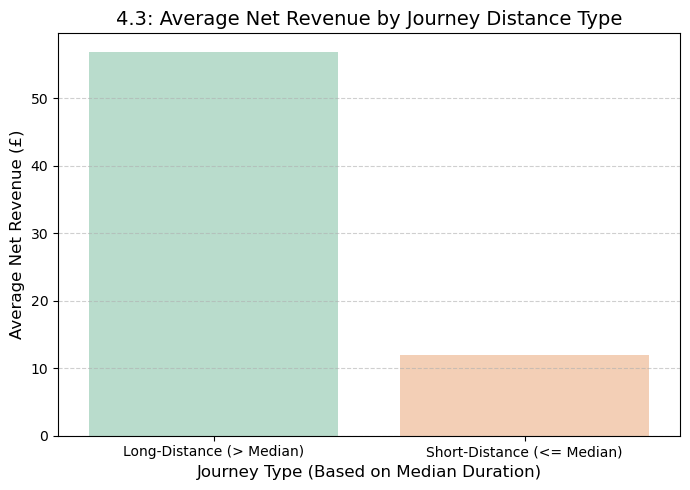

In [56]:
# Define the median duration to split the data
median_duration = df['Journey_Duration_Minutes'].median()

df['Distance_Type'] = df['Journey_Duration_Minutes'].apply(
    lambda x: 'Long-Distance (> Median)' if x > median_duration else 'Short-Distance (<= Median)')

# Aggregate to find the MEAN Net Revenue for each type
df_distance_profit = df.groupby('Distance_Type')['Net_Revenue'].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.barplot(x='Distance_Type', y='Net_Revenue', data=df_distance_profit, palette='Pastel2') 

plt.title('4.3: Average Net Revenue by Journey Distance Type', fontsize=14)
plt.xlabel('Journey Type (Based on Median Duration)', fontsize=12)
plt.ylabel('Average Net Revenue (£)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Distance_Avg_Profitability.png')
plt.show()

# SECTION 5: KPI Calculation

In [57]:
BOLD_START = '\033[1m'
BOLD_END = '\033[0m'

# 1. Overall Profitability Metrics
# Using the full cleaned DataFrame 'df'
total_gross_revenue = df['Price'].sum()
total_refund_amount = df['Refund_Amount'].sum()
total_net_revenue = df['Net_Revenue'].sum()
profit_margin = (total_net_revenue / total_gross_revenue) * 100

# 2. Operational Metrics
total_journeys = df.shape[0]
delayed_journeys = df[df['Journey Status'] == 'Delayed'].shape[0]
delay_rate = (delayed_journeys / total_journeys) * 100

# 3. Forecast Metrics (using the df_forecast_real DataFrame created in Cell 5)
avg_forecasted_rides = df_forecast_real['Forecasted_Rides'].mean()
avg_forecasted_revenue = df_forecast_real['Forecasted_Net_Revenue'].mean()


print("--- Key Performance Indicators (KPIs) ---")
print(f"Total Net Revenue (Historical): {BOLD_START}£{total_net_revenue:,.2f}{BOLD_END}")
print(f"Overall Profit Margin (Net/Gross): {BOLD_START}{profit_margin:.2f}%{BOLD_END}")
print(f"Total Refunded Amount: {BOLD_START}£{total_refund_amount:,.2f}{BOLD_END}")
print("---------------------------------------")
print(f"Journey Delay Rate: {BOLD_START}{delay_rate:.2f}%{BOLD_END}")
print(f"Average Forecasted Daily Rides (Next 30 Days): {BOLD_START}{avg_forecasted_rides:,.0f}{BOLD_END}")
print(f"Average Forecasted Daily Net Revenue: {BOLD_START}£{avg_forecasted_revenue:,.2f}{BOLD_END}")

--- Key Performance Indicators (KPIs) ---
Total Net Revenue (Historical): £722,570.00
Overall Profit Margin (Net/Gross): 97.39%
Total Refunded Amount: £19,351.00
---------------------------------------
Journey Delay Rate: 7.24%
Average Forecasted Daily Rides (Next 30 Days): 267
Average Forecasted Daily Net Revenue: £6,120.57
